In [28]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
import nice_layers as vnn
import torchvision
from imp import reload

In [40]:
#MNIST 

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                                            torchvision.transforms.Lambda(lambda x: torch.flatten(x))])
train_set = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=200, shuffle=False)


In [26]:
#CIFAR

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [35]:
nonneg = False
model = nn.Sequential(vnn.Linear(10, 784*10, 1200, nonneg=False, expanded_input=True),
                      vnn.tReLU(),
                      vnn.Linear(10, 1200, 600, nonneg=nonneg),
                      vnn.tReLU(),
                      vnn.Linear(10, 600, 1, nonneg=nonneg))

In [50]:
#update utilty
def set_model_grads(model, output, labels):
    targets = torch.eye(10, device=labels.device)[labels]
    output_error = F.softmax(output, dim=1) - targets
    for i in range(len(model)):
        layer = model[i]
        if type(layer) in (vnn.Conv2d, vnn.Linear):
            if (i == len(model) - 1) or (type(model[i+1]) not in (vnn.ReLU, vnn.tReLU)):
                mask = torch.ones(layer.mask_shape, device=output.device)
            else:
                mask = model[i+1].mask
            layer.set_grad(mask, output_error)
    nans = np.any([torch.any(torch.isnan(p)).item() for p in model.parameters()])
    if nans:
        print("Warning: NAN!")
            
            
def expand_input(input, category_dim):
    batch_dim, input_dim = input.shape
    expanded_input = torch.zeros(batch_dim, category_dim, category_dim*input_dim)
    for i in range(category_dim):
        expanded_input[:, i, i*input_dim:(i+1)*input_dim] = input
    return expanded_input

def expand_input_conv(input, category_dim):
    #input = (batch, channels, width, height)
    batch_size, in_channels = input.shape[:2]
    expanded_input = torch.zeros((batch_size, category_dim, in_channels*category_dim) + input.shape[2:])
    for i in range(category_dim):
        expanded_input[:, i, i*in_channels:(i+1)*in_channels] = input
    return expanded_input

In [37]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

for epoch_idx in range(1000):
    print(epoch_idx)
    epoch_loss = 0.
    epoch_correct = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        input = expand_input(data, 10)
        with torch.no_grad():
            out = model(input)[..., 0]
        epoch_loss += loss_fn(out, labels).item()
        epoch_correct += (out.argmax(dim=1) == labels).float().sum()
        opt.zero_grad()
        set_model_grads(model, out, labels)
        opt.step()
        for layer in model: layer.post_step_callback()
    print(epoch_loss / (batch_idx + 1))
    print(epoch_correct / 60000.)

0
Instantiated t with shape (10, 1200)
Instantiated t with shape (10, 600)


KeyboardInterrupt: 

In [38]:
num_correct = 0
for batch_idx, (data, labels) in enumerate(test_loader):
    input = expand_input(data, 10)
    with torch.no_grad():
        out = model.forward(input)[..., 0]
    num_correct += (out.argmax(dim=1) == labels).int().sum().item()
acc = num_correct / 10000.
acc

0.9174

In [375]:
def init_conv_l0(weight):
    out_channels, in_channels = weight.shape[:2]
    kernel_size = weight.shape[-1]
    W_shape = weight.shape[1:]
    for i in range(out_channels // 2):
        W = torch.randn(W_shape) * 1./np.sqrt((in_channels/10.) * kernel_size**2)
        weight[2*i] = W
        weight[2*i + 1] = -W

def init_conv(weight):
    out_channels, in_channels = weight.shape[:2]
    kernel_size = weight.shape[-1]
    W_shape = weight.shape[2:]
    for i in range(out_channels // 2):
        for j in range(in_channels // 2):
            W = torch.randn(W_shape) * 1./np.sqrt(0.25*in_channels * kernel_size**2)
            i1, i2 = i*2, i*2 + 1
            j1, j2 = j*2, j*2 + 1
            #if np.random.rand() < 0.5:
            weight[i1, j1] = F.relu(W)
            weight[i2, j2] = F.relu(W)
            #else:
            weight[i1, j2] = F.relu(-W)
            weight[i2, j1] = F.relu(-W)
                
def init_t(t):
    features = t.shape[1]
    for i in range(features // 2):
        t[:, 2*i + 1] = -t[:, 2*i]
                
            

Instantiated t with shape (10, 192, 16, 16)
Instantiated t with shape (10, 192, 5, 5)
Instantiated t with shape (10, 192, 1, 1)


(array([  7.,  20.,  96., 191., 366., 364., 150.,  60.,  23.,   3.]),
 array([-1.9084553 , -1.5186098 , -1.1287644 , -0.7389189 , -0.34907347,
         0.04077196,  0.4306174 ,  0.8204628 ,  1.2103083 ,  1.6001537 ,
         1.9899992 ], dtype=float32),
 <BarContainer object of 10 artists>)

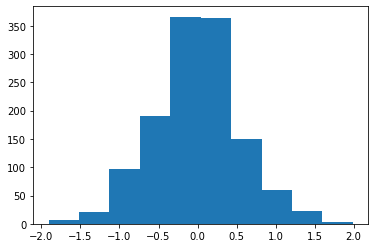

In [376]:
reload(vnn)
nonneg = True
model = nn.Sequential(vnn.Conv2d(10, 30, 96*2, 2, stride=2, nonneg=False, expanded_input=True),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 96*2, 96*2, 3, stride=3, nonneg=nonneg, expanded_input=False),
                      vnn.tReLU(),
                      vnn.Conv2d(10, 96*2, 96*2, 3, stride=3, nonneg=nonneg, expanded_input=False),
                      vnn.tReLU(),
                      vnn.Flatten(),
                      vnn.Linear(10, 96*2, 1, nonneg=nonneg)).to(0)

input = expand_input_conv(data, 10).to(0)
out = model(input)

with torch.no_grad():
    init_conv_l0(model[0].conv.weight)
    init_t(model[1].t)
    init_conv(model[2].conv.weight)
    init_t(model[3].t)
    init_conv(model[4].conv.weight)
    init_t(model[5].t)
    W_last = torch.abs(torch.randn(96) / np.sqrt(192. * 0.25))
    model[7].weight *= 0.
    model[7].weight[0, ::2] = W_last
    #model[7].weight[0, 1::2] = W_last
    #model[0].conv.weight *= 0.5
    #model[2].conv.weight *= 0.5
    #model[4].conv.weight *= 0.5

input = expand_input_conv(data, 10).to(0)
out = model(input)
plt.hist(out.cpu().detach().numpy().flatten())



In [340]:
input = expand_input_conv(data, 10).to(0)
model[:7](input)[0, 0] 

tensor([-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00, -5.1821e-02,
         5.1821e-02,  2.7705e-01, -2.7705e-01, -0.0000e+00,  0.0000e+00,
         0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,  4.4373e-02,
        -4.4373e-02,  1.5393e-02, -1.5393e-02,  4.6490e-01, -4.6490e-01,
         1.3764e-02, -1.3764e-02,  1.4162e-01, -1.4162e-01, -0.0000e+00,
         0.0000e+00, -0.0000e+00,  0.0000e+00, -2.0604e-01,  2.0604e-01,
         6.8027e-02, -6.8027e-02, -1.8308e-01,  1.8308e-01, -1.3404e-01,
         1.3404e-01,  0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,
        -1.5464e-01,  1.5464e-01,  0.0000e+00, -0.0000e+00,  0.0000e+00,
        -0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,
        -0.0000e+00,  0.0000e+00, -7.0340e-02,  7.0340e-02, -0.0000e+00,
         0.0000e+00, -6.2558e-02,  6.2558e-02,  1.8579e-02, -1.8579e-02,
         2.0959e-01, -2.0959e-01,  1.8493e-01, -1.8493e-01, -3.4754e-01,
         3.4754e-01,  3.9574e-01, -3.9574e-01,  1.0

In [390]:
loss_fn = nn.CrossEntropyLoss(reduction="mean")
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.4)

for epoch_idx in range(1000):
    print(epoch_idx)
    epoch_loss = 0.
    epoch_correct = 0.
    for batch_idx, (data, labels) in enumerate(train_loader):
        if batch_idx % 100 == 0:
            print(batch_idx)
        input = expand_input_conv(data, 10).to(0)
        with torch.no_grad():
            out = model(input)[..., 0]
        epoch_loss += loss_fn(out, labels.to(0)).item()
        c = (out.argmax(dim=1).cpu() == labels).float().sum().item()
        epoch_correct += c
        opt.zero_grad()
        set_model_grads(model, out, labels.to(0))
        opt.step()
        for layer in model: layer.post_step_callback()
    print(epoch_loss / (batch_idx + 1))
    print(epoch_correct / 50000.)

0
0
100
200
300
2.0907916781847433
0.248
1
0
100
200
300
2.0596694927996078
0.26162
2
0
100
200
300
2.039137040562642
0.27082
3
0
100
200
300
2.0258365250609414
0.27396
4
0
100
200
300
2.018586888642567
0.27696
5
0
100
200
300
2.011790730459306
0.27908
6
0
100
200
300
2.0072065225952422
0.28542
7
0
100
200
300
1.999770408701104
0.28518
8
0
100
200
300
1.994799063943536
0.28816
9
0
100
200
300
1.9896031508360372
0.28992
10
0
100
200
300
1.9834656715393066
0.29156
11
0
100
200
300
1.9774582230526467
0.2909
12
0
100
200
300
1.9729847932410667
0.29148
13
0
100
200
300
1.9673175433712542
0.29378
14
0
100
200
300
1.9628477715470296
0.29378
15
0
100
200
300
1.9623772107121888
0.29324
16
0
100
200
300
1.9601445045617536
0.2932
17
0
100
200
300
1.9596500689416285
0.29304
18
0


KeyboardInterrupt: 

In [391]:
opt = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)


In [397]:
input = expand_input_conv(data, 10).to(0)
with torch.no_grad():
    out = model(input)[..., 0]
opt.zero_grad()
set_model_grads(model, out, labels.to(0))
G1 = model[0].conv.weight.grad.detach().cpu().numpy()

In [393]:
input = expand_input_conv(data, 10).to(0)
out = model(input)[..., 0]
loss = loss_fn(out, labels.to(0))
opt.zero_grad()
loss.backward()
G2 = model[0].conv.weight.grad.detach().cpu().numpy()

In [394]:
from scipy.stats import pearsonr
pearsonr(G1.flatten(), G2.flatten())

(0.8082992550571558, 0.0)

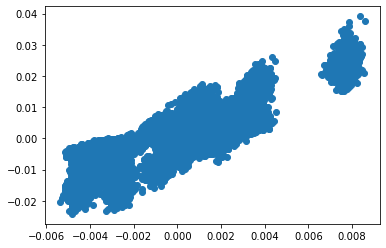

In [395]:
plt.scatter(G1.flatten(), G2.flatten())

In [382]:
from scipy.stats import linregress

In [398]:
linregress(G1.flatten(), G2.flatten())

LinregressResult(slope=2.4107578671313687, intercept=-2.459332929029321e-10, rvalue=0.8082992550571554, pvalue=0.0, stderr=0.011569273263664531)

In [251]:
1./0.003713009250588456

269.32332577450893